# TMDB Revenue Prediction

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [79]:
import pandas as pd

data = pd.read_csv("train.csv")

## Step 2: Data Exploration

In [80]:
data_explore = data.copy()

In [81]:
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [82]:
data_explore.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Since belongs_to_collection attribute is only present for sequel movies so lets create a new feature which will indicate whether movie is sequel or not.

In [83]:
data_explore['is_sequel'] = data_explore['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1).astype('int64')

In [84]:
def modify_date(x):
    """
    Given data format is mm/dd/YY. This function will extract the year, month and day on which movie is release.
    """
    x=str(x)
    year=x.split('/')[2]
    if int(year)<20:
        return x[:-2]+'20'+year
    else:
        return x[:-2]+'19'+year
    
data_explore['release_date']=data_explore['release_date'].apply(lambda x: modify_date(x))
data_explore['release_year'] = pd.DatetimeIndex(data_explore['release_date']).year
data_explore['release_month'] = pd.DatetimeIndex(data_explore['release_date']).month
data_explore['release_day'] = pd.DatetimeIndex(data_explore['release_date']).day
data_explore['release_dow'] = pd.DatetimeIndex(data_explore['release_date']).dayofweek

In [85]:
drop_cols = ['id', 'belongs_to_collection', 'homepage', 'imdb_id', 'release_date', 'poster_path', 'tagline', 'title']
data_explore = data_explore.drop(columns=drop_cols, axis=1)

In [86]:
nan_cols = data_explore.isna().sum()
nan_cols[nan_cols>0]

genres                    7
overview                  8
production_companies    156
production_countries     55
runtime                   2
spoken_languages         20
Keywords                276
cast                     13
crew                     16
dtype: int64

- Except runtime, all columns which contain NULL values are the columns which are multi-valued. So will replace them with empty set.
- NULL value in runtime will be replace by the median value.

In [87]:
data_explore.describe()

,budget,popularity,runtime,revenue,is_sequel,release_year,release_month,release_day,release_dow
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2.253133e+07,8.463274,107.856571,6.672585e+07,0.201333,1999.713000,6.775333,15.046333,3.269333
std,3.702609e+07,12.104000,22.086434,1.375323e+08,0.401063,15.423313,3.409115,8.632981,1.306150
min,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,1921.000000,1.000000,1.000000,0.000000
25%,0.000000e+00,4.018053,94.000000,2.379808e+06,0.000000,1993.000000,4.000000,8.000000,2.000000
50%,8.000000e+06,7.374861,104.000000,1.680707e+07,0.000000,2004.000000,7.000000,15.000000,4.000000
75%,2.900000e+07,10.890983,118.000000,6.891920e+07,0.000000,2011.000000,10.000000,22.000000,4.000000
max,3.800000e+08,294.337037,338.000000,1.519558e+09,1.000000,2017.000000,12.000000,31.000000,6.000000


- Min budget, runtime is zero
- Min revenue is one

In [88]:
import ast
dict_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

for col in dict_cols:
    data_explore[col] = data_explore[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

In [89]:
na_cols = data_explore.columns[data_explore.isna().any()].tolist()
na_cols.remove('overview')
na_cols.remove('runtime')
data_explore['runtime'].fillna(value=data_explore['runtime'].median(), inplace=True)
data_explore['overview'].fillna(value='', inplace=True)
for col in na_cols:
    data_explore[col].fillna(value='', inplace=True)

In [90]:
def get_names(x, col):
    """
        Get the name field from each JSON object.
        For crew field, considering the Director only.
        For cast field, considering the first 3 cast members. Generally they are the main roles from movie.
    """
    names = []
    for item in x:
        if col=='crew':
            if item['job']=='Director':
                names.append(item['name'])
        elif col=='cast':
            if item['order'] in (0, 1, 2):
                names.append(item['name'])
        else:
            names.append(item['name'])
    return names
    
for col in dict_cols:
    data_explore[col] = data_explore[col].apply(lambda x: get_names(x, col))

In [91]:
data_explore.head(n=3)

,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,Keywords,cast,crew,revenue,is_sequel,release_year,release_month,release_day,release_dow
0,14000000,[Comedy],en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],93.0,[English],Released,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke]",[Steve Pink],12314651,1,2015,2,20,4
1,40000000,"[Comedy, Drama, Family, Romance]",en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[United States of America],113.0,[English],Released,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizondo]",[Garry Marshall],95149435,1,2004,8,6,4
2,3300000,[Drama],en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],105.0,[English],Released,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist]",[Damien Chazelle],13092000,0,2014,10,10,4


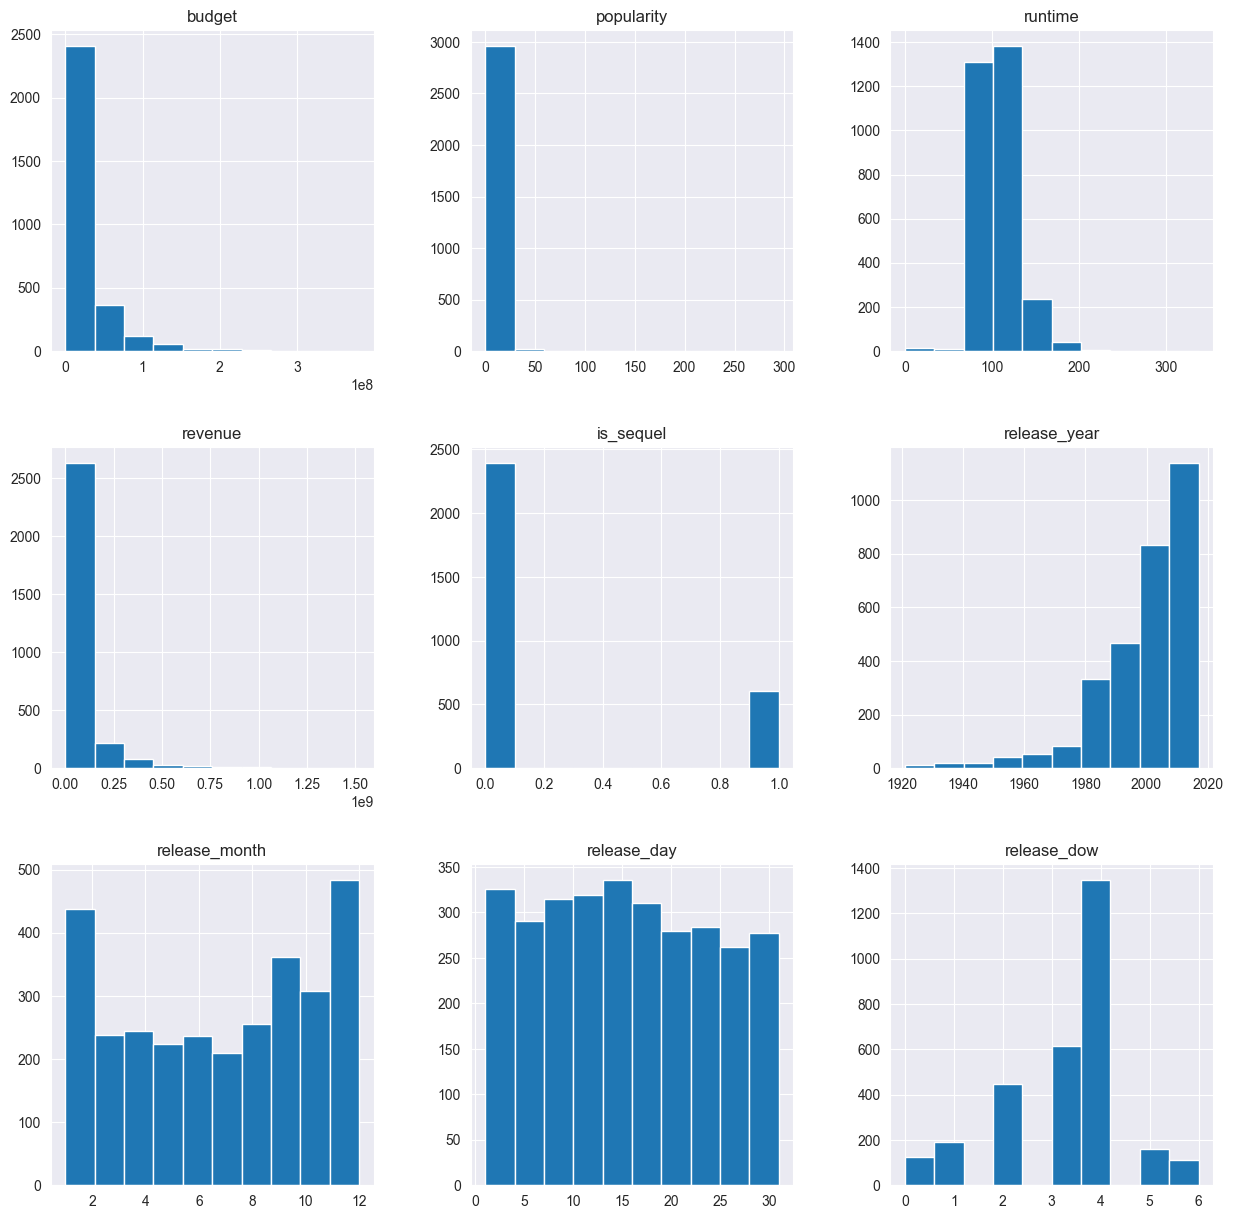

In [92]:
data_explore.hist(figsize=(15, 15))
plt.show()

In [93]:
highest_revenue_movies = data_explore.sort_values('revenue', ascending=False).head(n=20)
highest_revenue_movies['revenue(million)'] = highest_revenue_movies['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_revenue_movies['budget(million)'] = highest_revenue_movies['budget'].apply(lambda x : x//1000000)    # revenue in millions
highest_revenue_movies[['genres', 'original_title', 'production_companies', 'popularity', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,original_title,production_companies,popularity,cast,crew,budget(million),revenue(million)
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
1761,[Action],Furious 7,"[Universal Pictures, Original Film, Fuji Telev...",27.275687,"[Vin Diesel, Paul Walker, Dwayne Johnson]",[James Wan],190,1506
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
684,"[Family, Fantasy, Romance]",Beauty and the Beast,"[Walt Disney Pictures, Mandeville Films]",287.253654,"[Emma Watson, Dan Stevens, Luke Evans]",[Bill Condon],160,1262
2322,"[Action, Science Fiction, Adventure]",Transformers: Dark of the Moon,"[Paramount Pictures, Di Bonaventura Pictures, ...",4.503505,"[Shia LaBeouf, John Malkovich, Ken Jeong]",[Michael Bay],195,1123
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,[],[],250,1084
2135,"[Adventure, Action, Fantasy]",Pirates of the Caribbean: On Stranger Tides,"[Walt Disney Pictures, Jerry Bruckheimer Films...",27.887720,"[Johnny Depp, Pen√©lope Cruz, Ian McShane]",[Rob Marshall],380,1045
2562,"[Adventure, Animation, Comedy, Family]",Finding Dory,"[Walt Disney Pictures, Pixar Animation Studios...",14.477677,"[Ellen DeGeneres, Albert Brooks, Hayden Rolence]","[Andrew Stanton, Angus MacLane]",200,1028
881,"[Family, Fantasy, Adventure]",Alice in Wonderland,"[Walt Disney Pictures, Team Todd, Tim Burton P...",17.285093,"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",[Tim Burton],200,1025
734,"[Animation, Adventure, Family, Comedy]",Zootopia,"[Walt Disney Pictures, Walt Disney Animation S...",26.024868,"[Ginnifer Goodwin, Jason Bateman, Shakira]","[Byron Howard, Rich Moore, Jared Bush]",150,1023


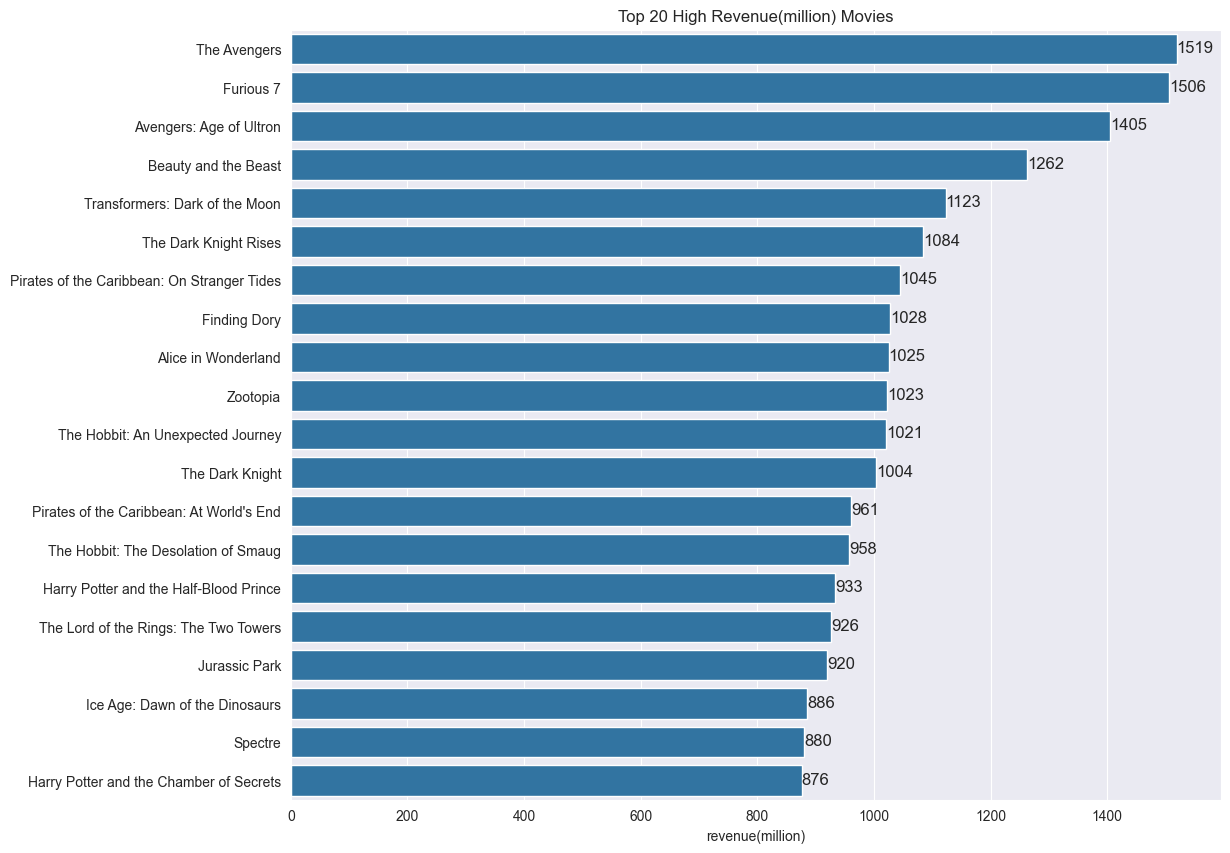

In [94]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='original_title', x='revenue(million)', data=highest_revenue_movies, order=highest_revenue_movies.sort_values('revenue(million)', ascending=False).original_title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 20 High Revenue(million) Movies', fontsize=12)
plt.ylabel('')
plt.show()

### Top 20 High Budget Movies

In [95]:
highest_budget_movies = data_explore.sort_values('budget', ascending=False).head(n=20)
highest_budget_movies['revenue(million)'] = highest_budget_movies['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_budget_movies['budget(million)'] = highest_budget_movies['budget'].apply(lambda x : x//1000000)    # revenue in millions
highest_budget_movies[['genres', 'original_title', 'production_companies', 'popularity', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,original_title,production_companies,popularity,cast,crew,budget(million),revenue(million)
2135,"[Adventure, Action, Fantasy]",Pirates of the Caribbean: On Stranger Tides,"[Walt Disney Pictures, Jerry Bruckheimer Films...",27.887720,"[Johnny Depp, Pen√©lope Cruz, Ian McShane]",[Rob Marshall],380,1045
2209,"[Adventure, Fantasy, Action]",Pirates of the Caribbean: At World's End,"[Walt Disney Pictures, Jerry Bruckheimer Films...",31.363664,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],300,961
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
1425,"[Adventure, Fantasy, Action, Science Fiction]",Superman Returns,"[DC Comics, Legendary Pictures, Warner Bros., ...",13.284712,"[Brandon Routh, Kevin Spacey, Kate Bosworth]",[Bryan Singer],270,391
1270,"[Action, Adventure, Science Fiction]",John Carter,[Walt Disney Pictures],14.670353,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],260,284
1630,"[Action, Science Fiction, Thriller, Adventure]",Transformers: The Last Knight,"[Paramount Pictures, Di Bonaventura Pictures, ...",39.186819,"[Mark Wahlberg, Josh Duhamel, Laura Haddock]",[Michael Bay],260,604
2532,"[Adventure, Fantasy, Action]",The Hobbit: An Unexpected Journey,"[WingNut Films, New Line Cinema, Warner Bros. ...",23.253089,"[Ian McKellen, Martin Freeman, Richard Armitage]",[Peter Jackson],250,1021
961,"[Adventure, Fantasy, Family]",Harry Potter and the Half-Blood Prince,"[Warner Bros., Heyday Films]",19.083723,"[Daniel Radcliffe, Rupert Grint, Emma Watson]",[David Yates],250,933
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,[],[],250,1084
666,"[Adventure, Fantasy]",The Hobbit: The Desolation of Smaug,"[WingNut Films, New Line Cinema, Warner Bros. ...",20.644776,"[Martin Freeman, Ian McKellen, Richard Armitage]",[Peter Jackson],250,958


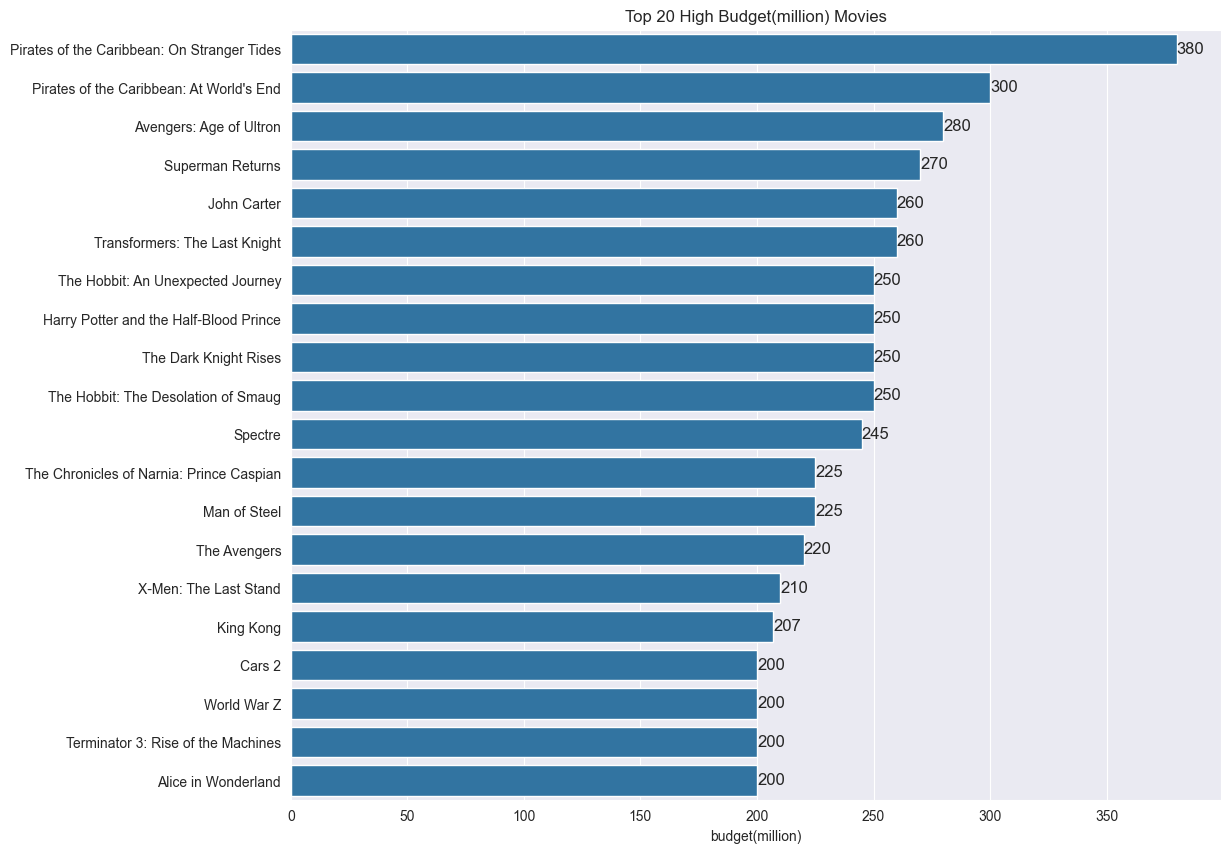

In [96]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='original_title', x='budget(million)', data=highest_budget_movies, order=highest_budget_movies.sort_values('budget(million)', ascending=False).original_title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 20 High Budget(million) Movies', fontsize=12)
plt.ylabel('')
plt.show()

### Genres

In [97]:
data_explore_enc = data_explore['genres'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')
data_explore_genres = pd.concat([data_explore, data_explore_enc], axis=1)
genres = data_explore_enc.columns
data_explore_genres.head(n=3)

,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,Keywords,cast,crew,revenue,is_sequel,release_year,release_month,release_day,release_dow,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,14000000,[Comedy],en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],93.0,[English],Released,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke]",[Steve Pink],12314651,1,2015,2,20,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40000000,"[Comedy, Drama, Family, Romance]",en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[United States of America],113.0,[English],Released,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizondo]",[Garry Marshall],95149435,1,2004,8,6,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3300000,[Drama],en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],105.0,[English],Released,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist]",[Damien Chazelle],13092000,0,2014,10,10,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
genres_info = []
for col in genres:
    total_movies, total_budget, median_budget, total_revenue, median_revenue, median_popularity=0, 0, 0, 0, 0, 0
    total_movies = data_explore_genres[data_explore_genres[col]==1][col].count()
    total_budget = data_explore_genres[data_explore_genres[col]==1]['budget'].sum()
    median_budget = data_explore_genres[data_explore_genres[col]==1]['budget'].median()
    total_revenue = data_explore_genres[data_explore_genres[col]==1]['revenue'].sum()
    median_revenue = data_explore_genres[data_explore_genres[col]==1]['revenue'].median()
    median_popularity = data_explore_genres[data_explore_genres[col]==1]['popularity'].median()
    genres_info.append([col, total_movies, total_budget, median_budget, total_revenue, median_revenue, median_popularity])

In [99]:
genres_info = pd.DataFrame(genres_info, columns=['genres', 'movies_count', 'total_budget', 'median_budget', 'total_revenue', 'median_revenue', 'median_popularity'])
genres_info['total_budget(million)'] = genres_info['total_budget'].apply(lambda x : x//1000000)    # budget in millions
genres_info['median_budget(million)'] = genres_info['median_budget'].apply(lambda x : x//1000000)    # budget in millions
genres_info['total_revenue(million)'] = genres_info['total_revenue'].apply(lambda x : x//1000000)    # revenue in millions
genres_info['median_revenue(million)'] = genres_info['median_revenue'].apply(lambda x : x//1000000)    # revenue in millions
genres_info[['genres', 'movies_count', 'total_budget(million)', 'median_budget(million)', 'total_revenue(million)', 'median_revenue(million)', 'median_popularity']]

,genres,movies_count,total_budget(million),median_budget(million),total_revenue(million),median_revenue(million),median_popularity
0,Comedy,1028,19614,8.0,62580,18.0,6.905488
1,Drama,1531,25733,6.0,69516,11.0,6.793972
2,Family,260,11048,24.0,36113,57.0,8.416440
3,Romance,571,8944,5.0,30094,14.0,6.370105
4,Thriller,789,20873,13.0,53917,21.0,8.371005
5,Action,741,29934,20.0,82283,36.0,8.345985
6,Animation,141,5967,23.0,20830,36.0,9.409701
7,Adventure,439,23738,28.0,77180,59.0,9.961184
8,Horror,301,4578,6.0,15865,17.0,8.122042
9,Documentary,87,76,0.0,403,0.0,1.949044


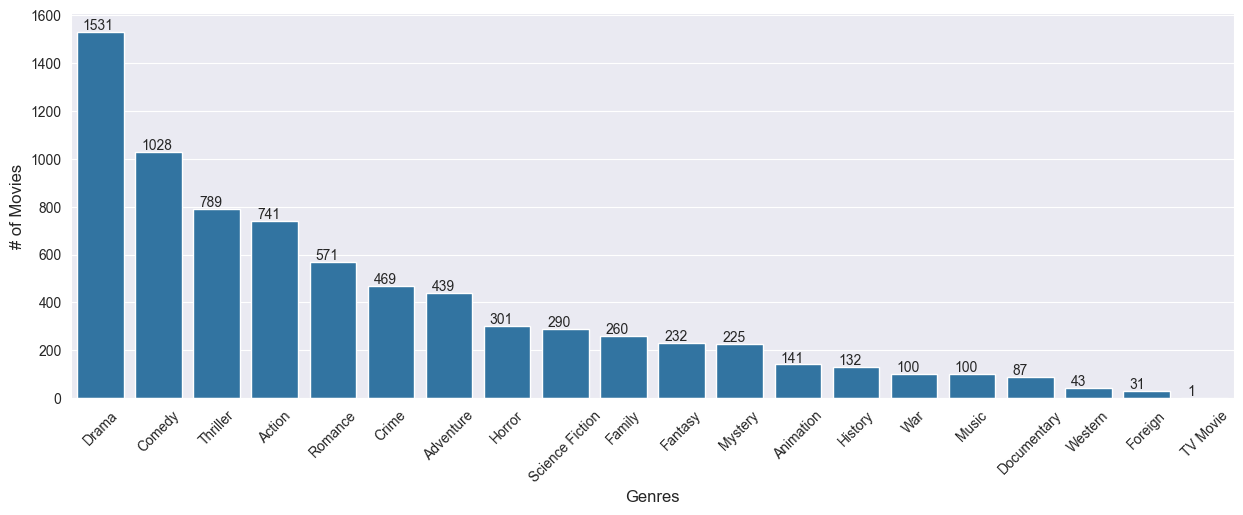

In [100]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='movies_count', data=genres_info, order=genres_info.sort_values('movies_count', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.1, p.get_height()+10))
plt.xticks(rotation=45)
plt.ylabel('# of Movies', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

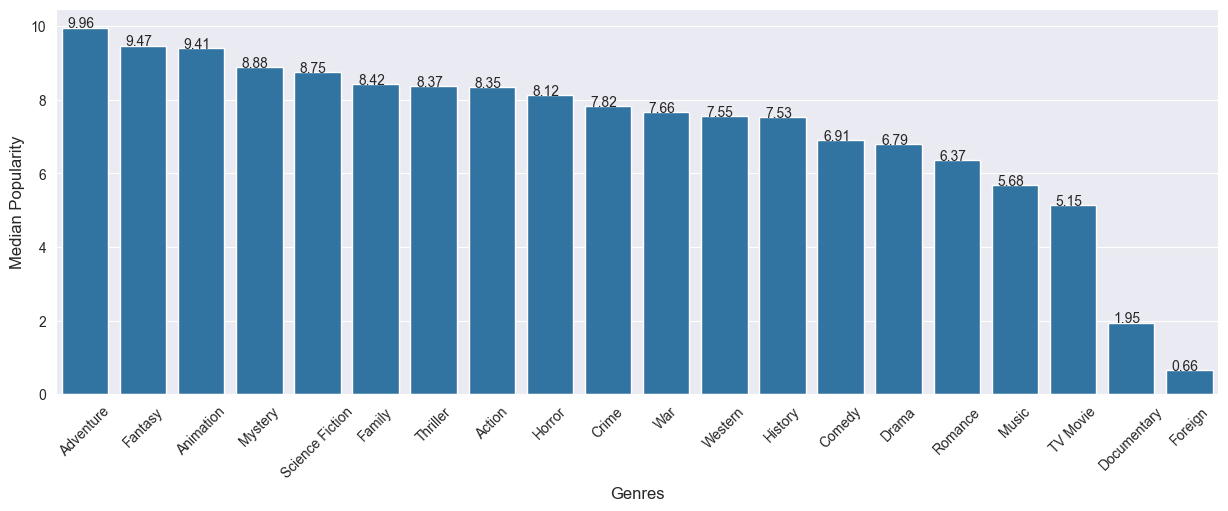

In [101]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='median_popularity', data=genres_info, order=genres_info.sort_values('median_popularity', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(np.round(p.get_height(), 2)), (p.get_x()+0.1, p.get_height()))
plt.xticks(rotation=45)
plt.ylabel('Median Popularity', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

### Revenue

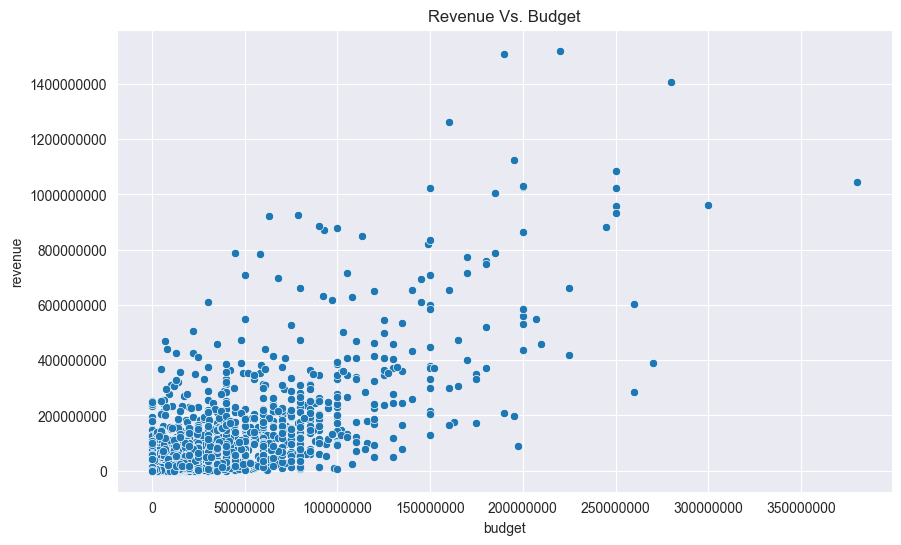

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget', y='revenue', data=data_explore)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Revenue Vs. Budget')
plt.show()

#### Observation:
   - There is not any clear trend between budget and revenue. But we can see that higher budget films generally earn more compare to small budget films.

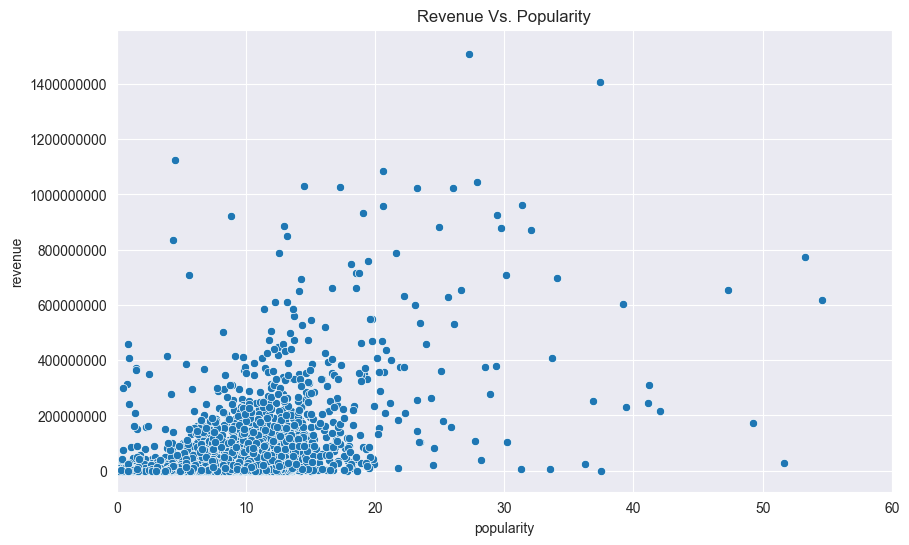

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='revenue', data=data_explore)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Revenue Vs. Popularity')
plt.xlim(0, 60)
plt.show()

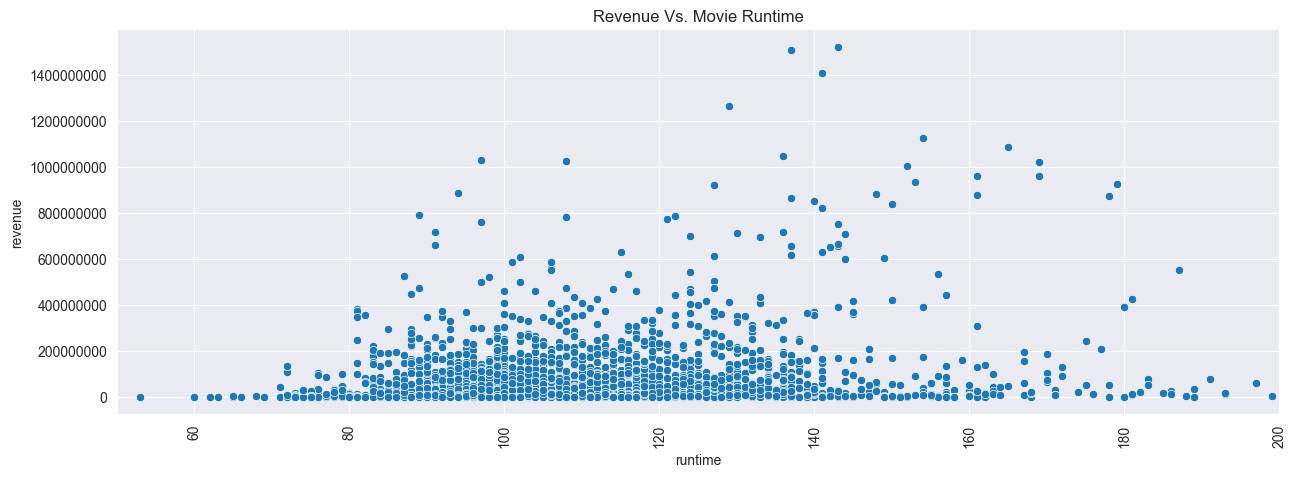

In [104]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x='runtime', y='revenue', data=data_explore)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Revenue Vs. Movie Runtime')
plt.xlim(50, 200)
plt.show()

(31.5, 89.5)

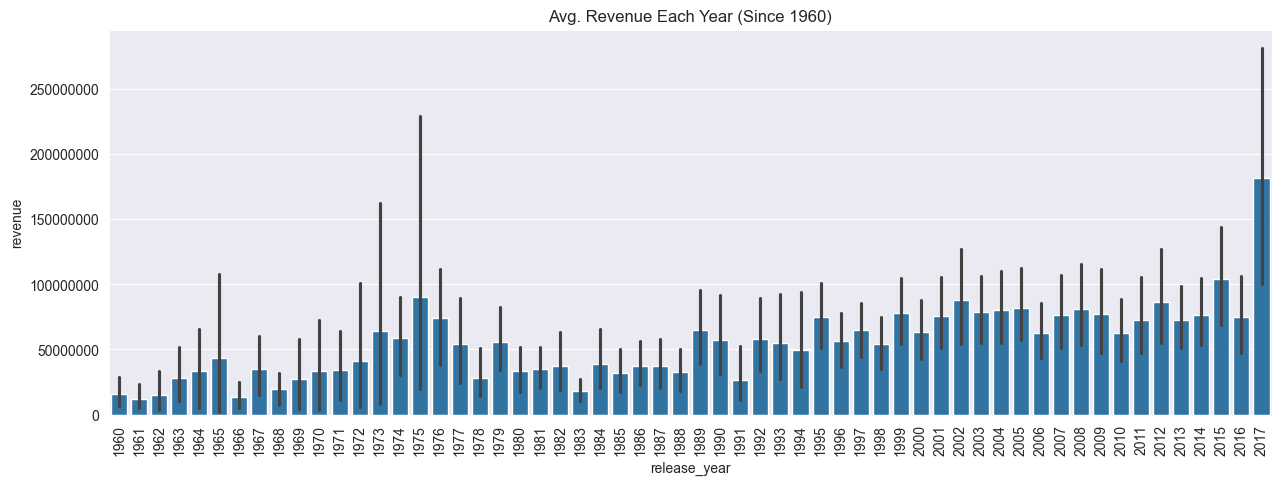

In [105]:
plt.figure(figsize=(15, 5))
sns.barplot(x='release_year', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue Each Year (Since 1960)')
ax.set_xlim(left=31.5)

Text(0.5, 1.0, 'Avg. Revenue Each Month')

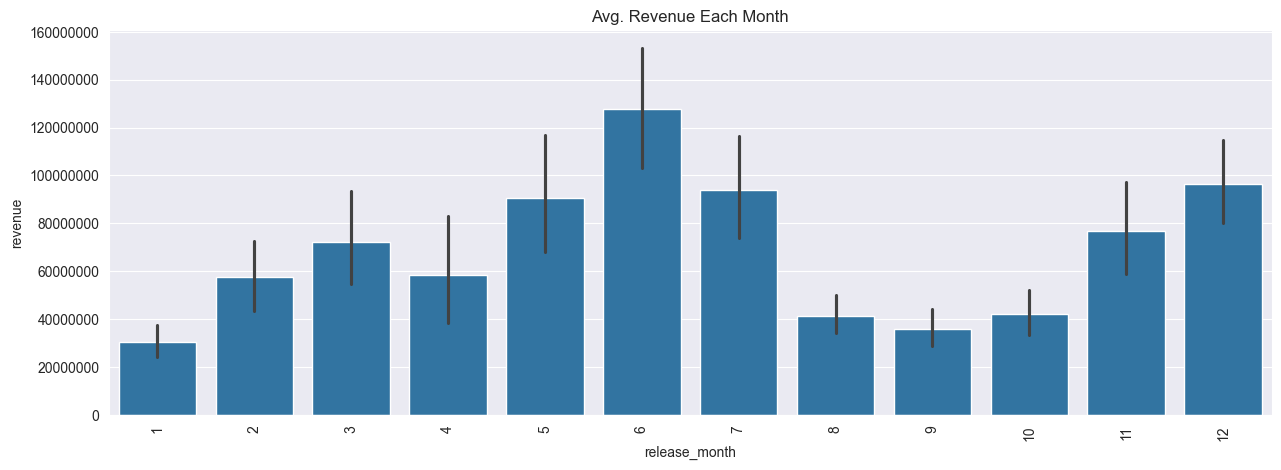

In [106]:
plt.figure(figsize=(15, 5))
sns.barplot(x='release_month', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue Each Month')

Text(0.5, 1.0, 'Avg. Revenue on Each Day of Week')

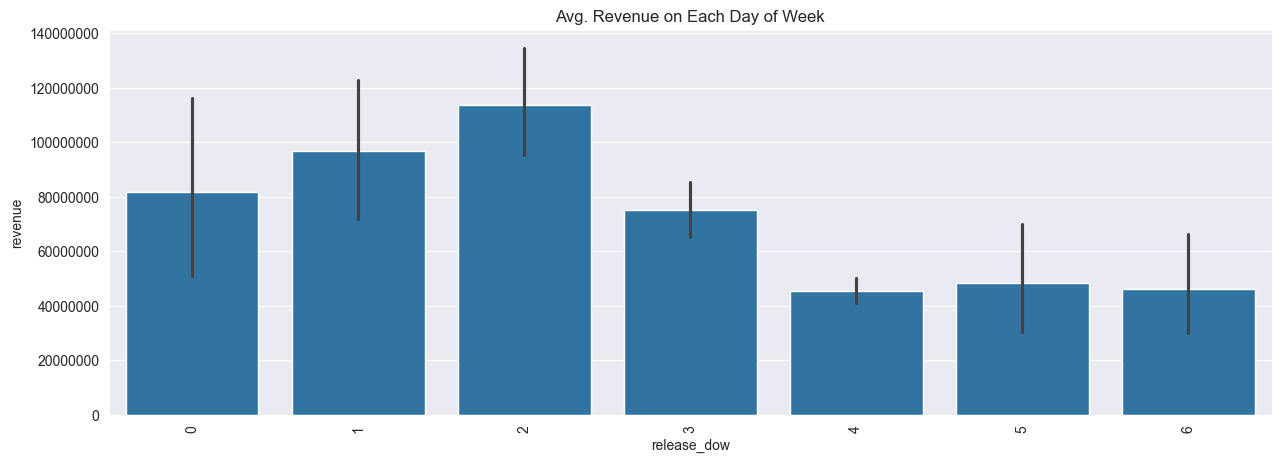

In [107]:
plt.figure(figsize=(15, 5))
sns.barplot(x='release_dow', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue on Each Day of Week')

(-0.5, 15.5)

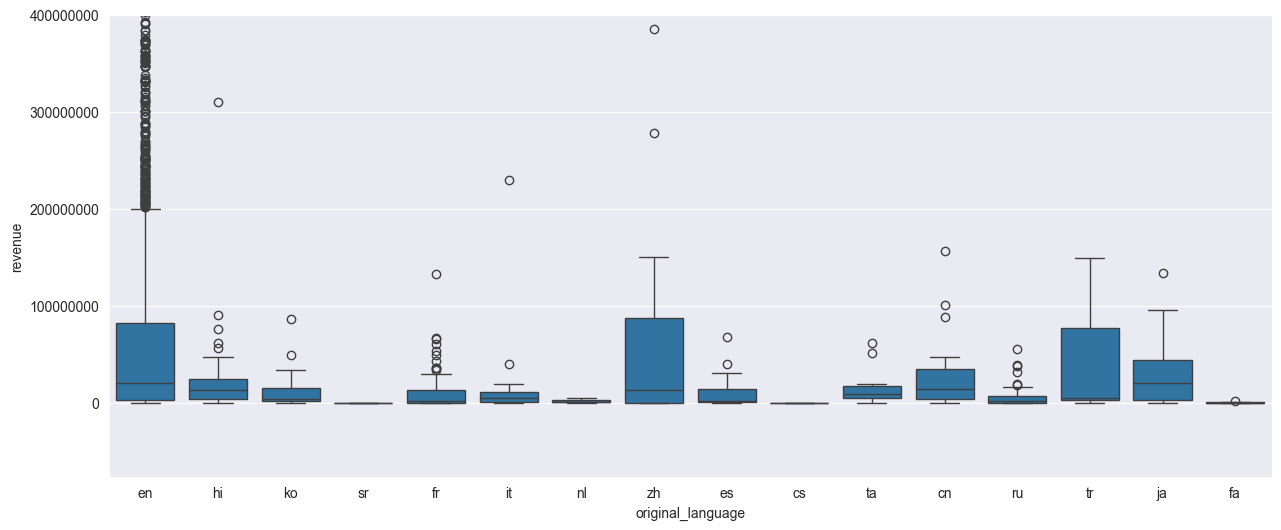

In [108]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='original_language', y='revenue', data=data_explore)
# plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylim(top=400000000)
ax.set_xlim(right=15.5)

In [109]:
def boxplot_sorted(df, by, column):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.mean().sort_values(ascending=False)
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot()

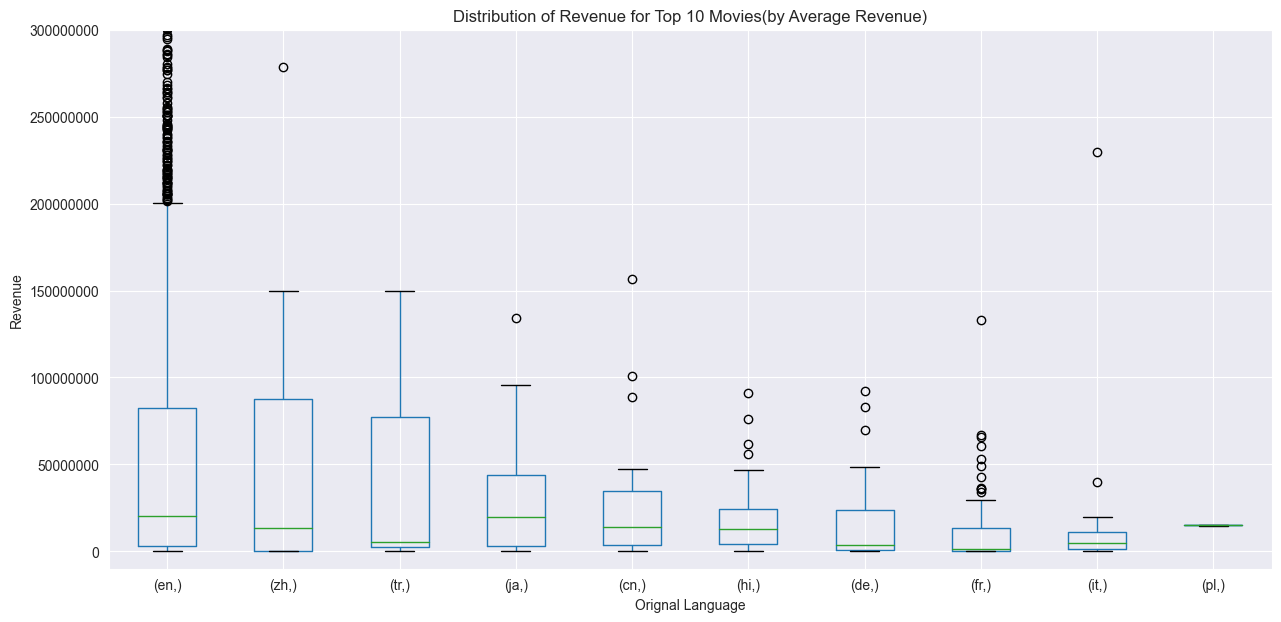

In [110]:
plt.figure(figsize=(15, 7))
axes = boxplot_sorted(data_explore, by = ['original_language'], column = 'revenue')
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylim((-10000000, 300000000))
ax.set_xlim(right=10.5)
plt.xlabel('Orignal Language')
plt.ylabel('Revenue')
plt.title('Distribution of Revenue for Top 10 Movies(by Average Revenue)')
plt.show()

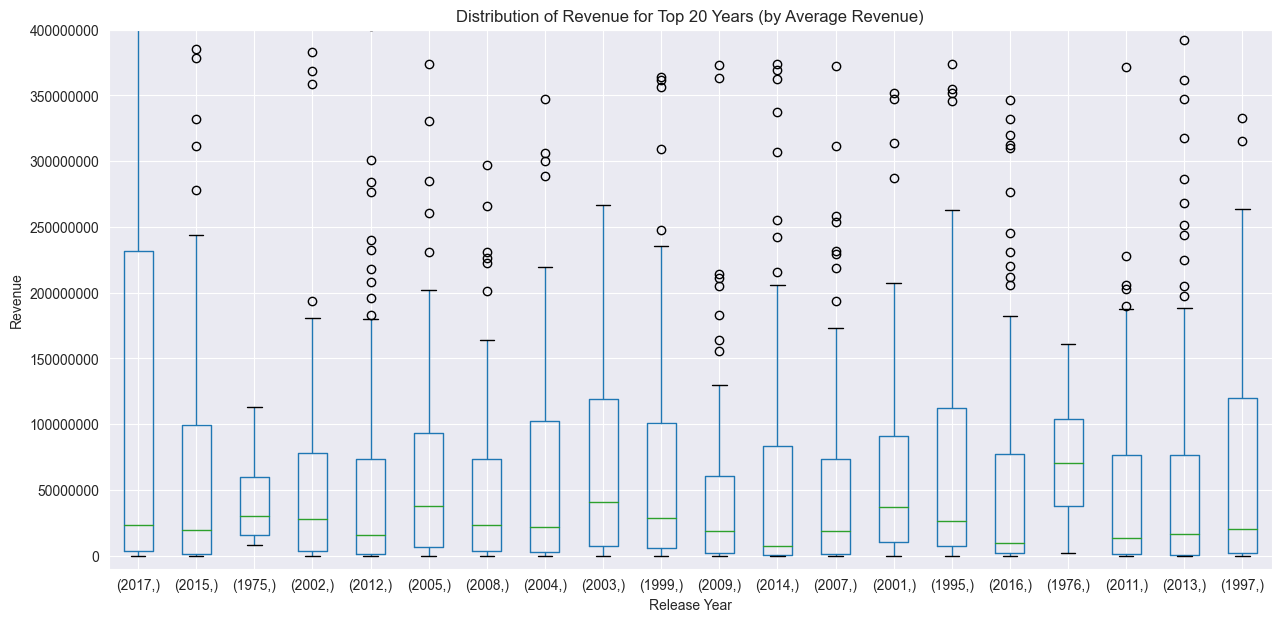

In [111]:
plt.figure(figsize=(15, 7))
axes = boxplot_sorted(data_explore, by = ['release_year'], column = 'revenue')
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylim((-10000000, 400000000))
ax.set_xlim(right=20.5)
plt.xlabel('Release Year')
plt.ylabel('Revenue')
plt.title('Distribution of Revenue for Top 20 Years (by Average Revenue)')
plt.show()

#### Pipeline

- In this step I will create a pipeline to handle all data preprocessing operations.
- Pipeline will do following tasks:
    - Dropping unwanted columns
    - Fill null values
    - Scaling numerical features
    - Encoding single valued & multivalued categorical fields
    - Creating new features from existing ones
    

In [112]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MultiLabelBinarizer

In [113]:
X = data.drop(columns=['revenue'], axis=1).copy()
y = data['revenue'].copy()
X.shape, y.shape

((3000, 22), (3000,))

In [114]:
from collections import Counter
top_30_values = dict()

list_of_genres_names = list(X['genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_genres = (Counter([i for j in list_of_genres_names for i in j]).most_common(30))
top_30_values['genres'] = [x for x, y in top_30_genres]

list_of_production_companies_names = list(X['production_companies'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_production_companies = (Counter([i for j in list_of_production_companies_names for i in j]).most_common(30))
top_30_values['production_companies'] = [x for x, y in top_30_production_companies]

list_of_production_countries_names = list(X['production_countries'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_production_countries = (Counter([i for j in list_of_production_countries_names for i in j]).most_common(30))
top_30_values['production_countries'] = [x for x, y in top_30_production_countries]

list_of_keywords = list(X['Keywords'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_30_keywords = (Counter([i for j in list_of_keywords for i in j]).most_common(30))
top_30_values['Keywords'] = [x for x, y in top_30_keywords]

list_of_cast_names = list(X['cast'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x)).apply(lambda x: [i['name'] for i in x if i['order'] in (0, 1, 2)] if x != {} else []).values)
top_30_cast = (Counter([i for j in list_of_cast_names for i in j]).most_common(30))
top_30_values['cast'] = [x for x, y in top_30_cast]

In [115]:
drop_cols = ['id', 'homepage', 'imdb_id', 'original_title', 'spoken_languages', 'overview', 'poster_path', 'tagline', 'title', 'crew']
encoded_cols = [] # This will contain all the encoded column names of multivalued field

In [116]:
class CustomAttr(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        try:
            X['is_sequel'] = X['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
#             print("is_sequel attribute added!")
            
            X['release_date']= X['release_date'].apply(lambda x: self.modify_date(x))
            
            X['release_year'] = pd.DatetimeIndex(X['release_date']).year
#             print("release_year attribute added!")
            
            X['release_month'] = pd.DatetimeIndex(X['release_date']).month
#             print("release_month attribute added!")
            
            X['release_day'] = pd.DatetimeIndex(X['release_date']).day
#             print("release_day attribute added!")
            
            X['release_dow'] = pd.DatetimeIndex(X['release_date']).dayofweek
#             print("release_dow attribute added!")
            
            X = X.drop(['belongs_to_collection', 'release_date'], axis=1)
#             print("belongs_to_collection, release_date attribute removed!")
            return X
        except Exception as e:
            print("CustomAttr: Exception caught: {}".format(e))

    @staticmethod
    def modify_date(x):
        """
            Converting date: mm/dd/YY to mm/dd/YYYY
            NaN date fields are handle here only.
        """
        try:
            if x is np.nan:
                x='01/01/00'
            x=str(x)
            year=x.split('/')[2]
            if int(year)<20:
                return x[:-2]+'20'+year
            else:
                return x[:-2]+'19'+year
        except Exception as e:
            print("CustomAttr: modify_date() function -  exception caught for date {}: {}".format(x,e))

In [117]:
class JSONHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        For each multivalued field, there will be a MultiLabelBinarizer.
        """
        self.mlbs = dict()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in list(X.columns):
            try:
                X[col] = X[col].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
                X[col] = X[col].apply(lambda x: self.get_names(x, col))
                if not (col in self.mlbs.keys()):
                    self.mlbs[col] = MultiLabelBinarizer()
                    X_enc = pd.DataFrame(self.mlbs[col].fit_transform(X[col]),columns=self.mlbs[col].classes_, 
                                         index=X.index)
                    encoded_cols.extend(list(self.mlbs[col].classes_))
                else:
                    X_enc = pd.DataFrame(self.mlbs[col].transform(X[col]),columns=self.mlbs[col].classes_, 
                                         index=X.index)
                X = X.drop(col, axis=1)
                X = pd.concat([X, X_enc], axis=1)
#                 print("{}, {}, {}".format(col, X_enc.shape, X.shape))
#                 print("{} attribute encoded &  removed!".format(col))
            except Exception as e:
                print("JSONHandler: Exception caught for {}: {}".format(col,e))
        return X
       

    @staticmethod
    def get_names(x, col):
        """
            Get the name field value from JSON object.
        """
        names = []
        try:
            names = [item['name'] for item in x if item['name'] in top_30_values[col]]
            if len(names)==0:
                names.append('other_'+col)
            return names
        except Exception as e:
            print("JSONHandler: get_names() function -  exception caught {}: {}".format(x,e))

In [118]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', PowerTransformer())])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

pre_process = ColumnTransformer([('drop_cols', 'drop', drop_cols),
                                 ('num_process', num_pipeline, ['budget', 'popularity', 'runtime']),
                                 ('add_custom_attrs', CustomAttr(), ['belongs_to_collection', 'release_date']),
                                 ('cat_process', cat_pipeline, ['original_language', 'status']),
                                 ('jason_handler', JSONHandler(), ['genres', 'production_companies', 'production_countries', 'Keywords', 'cast'])], remainder='passthrough')

X_transformed = pre_process.fit_transform(X)
X_transformed.shape

(3000, 191)

In [119]:
from sklearn.model_selection import train_test_split

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, np.log1p(y), test_size=0.2, random_state=42)
X_train_transformed.shape, X_test_transformed.shape

((2400, 191), (600, 191))

In [120]:
feature_columns = ['budget', 'popularity', 'runtime', 'is_sequel', 'release_year', 'release_month', 'release_day', 'release_dow'] + list(pre_process.transformers_[3][1]['cat_enc'].get_feature_names_out(['original_language', 'status'])) + encoded_cols
len(feature_columns)

191

## Step 4: Modelling

In [121]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

In [122]:
from sklearn.model_selection import cross_val_score
import numpy as np

results = []

def performance_measures(model, store_results=True):
    # Train RMSE
    train_rmses = cross_val_score(model, X_train_transformed, y_train, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    train_rmses *= -1
    train_mean_rmse = np.mean(train_rmses)
    
    # Test RMSE
    test_rmses = cross_val_score(model, X_test_transformed, y_test, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    test_rmses *= -1
    test_mean_rmse = np.mean(test_rmses)
    
    # Train R^2
    train_r2s = cross_val_score(model, X_train_transformed, y_train, scoring='r2', cv=kf, n_jobs=-1)
    train_mean_r2 = np.mean(train_r2s) - .2
    
    # Test R^2
    test_r2s = cross_val_score(model, X_test_transformed, y_test, scoring='r2', cv=kf, n_jobs=-1)
    test_mean_r2 = np.mean(test_r2s) - .2
    
    # Print results
    print("Train Mean RMSE: {:.4f}, Train Mean R^2: {:.4f}".format(train_mean_rmse, train_mean_r2))
    print("Test Mean RMSE: {:.4f}, Test Mean R^2: {:.4f}".format(test_mean_rmse, test_mean_r2))
    
    # Store results
    if store_results:
        results.append([model.__class__.__name__, train_mean_rmse, test_mean_rmse, train_mean_r2, test_mean_r2])


In [123]:
def plot_feature_importance(feature_columns, importance_values):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)

    imp = pd.DataFrame(feature_imp[0:15], columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('15 Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

In [124]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, random_state=42)
ridge_reg.fit(X_train_transformed, y_train)

Ridge(alpha=1, random_state=42)

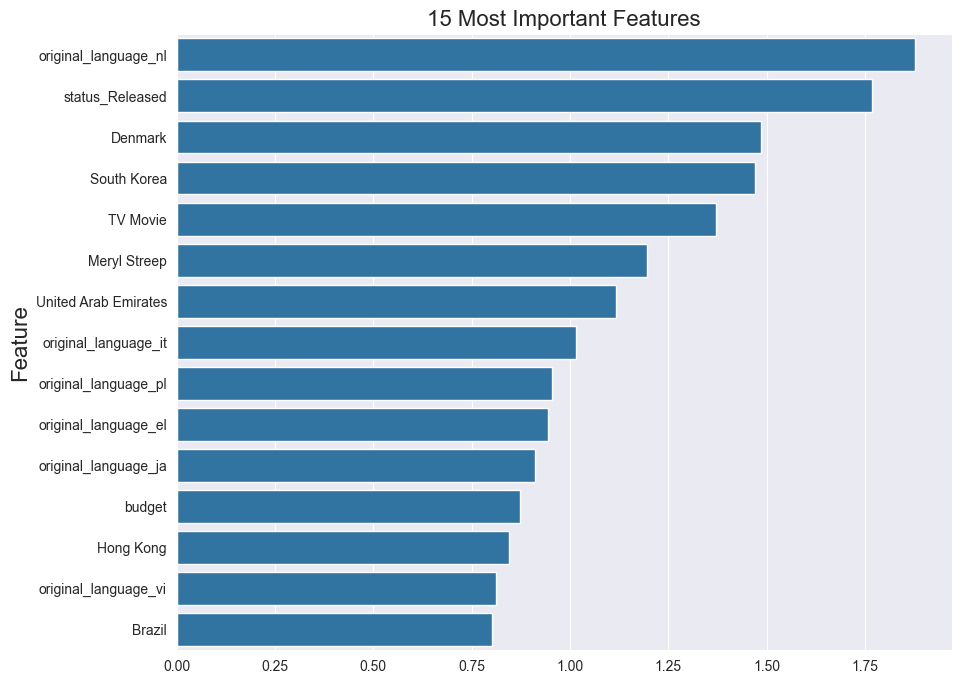

In [125]:
plot_feature_importance(feature_columns, ridge_reg.coef_)

In [126]:
performance_measures(ridge_reg) 

Train Mean RMSE: 2.3753, Train Mean R^2: 0.2035
Test Mean RMSE: 2.3631, Test Mean R^2: 0.1730


In [127]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, max_depth=16, max_features=0.2, n_jobs=-1, random_state=42)
forest_reg.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=16, max_features=0.2, n_estimators=500,
                      n_jobs=-1, random_state=42)

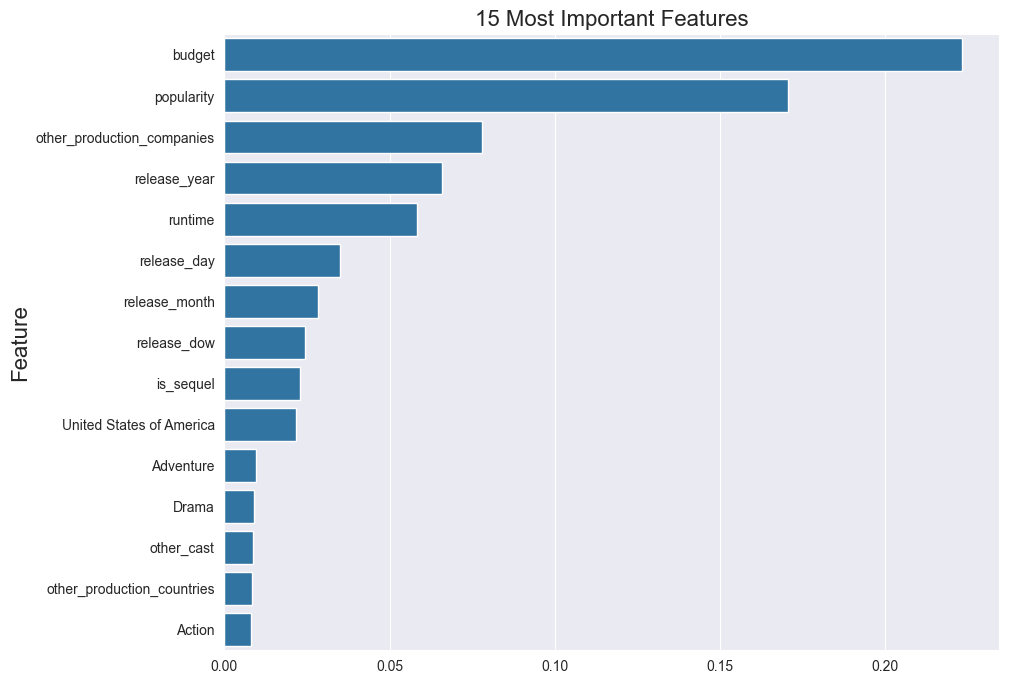

In [128]:
plot_feature_importance(feature_columns, forest_reg.feature_importances_)

In [129]:
performance_measures(forest_reg)

Train Mean RMSE: 2.1980, Train Mean R^2: 0.2890
Test Mean RMSE: 2.0929, Test Mean R^2: 0.3083


In [130]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators = 1000, max_depth = 14, learning_rate = 0.01, 
                       gamma=1.0, subsample = 0.7, colsample_bytree = 0.6, colsample_bylevel = 0.5, 
                       random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_transformed, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

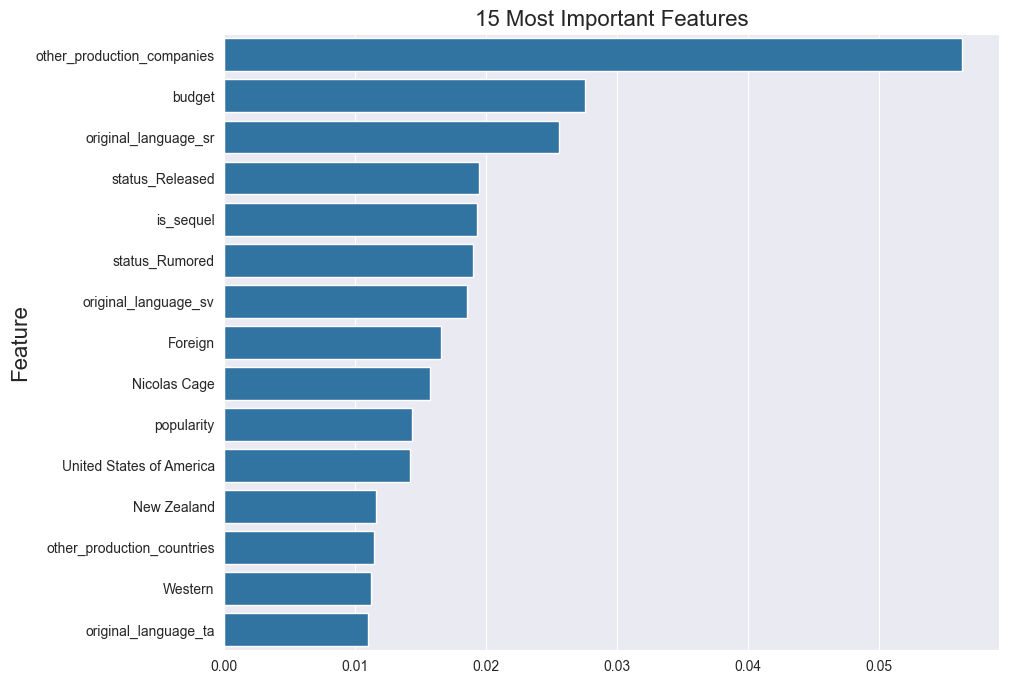

In [131]:
plot_feature_importance(feature_columns, xgb_reg.feature_importances_)

In [132]:
performance_measures(xgb_reg)

Train Mean RMSE: 2.2368, Train Mean R^2: 0.2709
Test Mean RMSE: 2.1481, Test Mean R^2: 0.2821


In [133]:
from catboost import CatBoostRegressor

cat_boost_reg = CatBoostRegressor(loss_function='RMSE', bagging_temperature = 0.3, colsample_bylevel = 0.7, 
                                  depth = 9, eval_metric = 'RMSE', iterations = 1500, 
                                  random_state=42, verbose=0)
cat_boost_reg.fit(X_train_transformed, y_train)

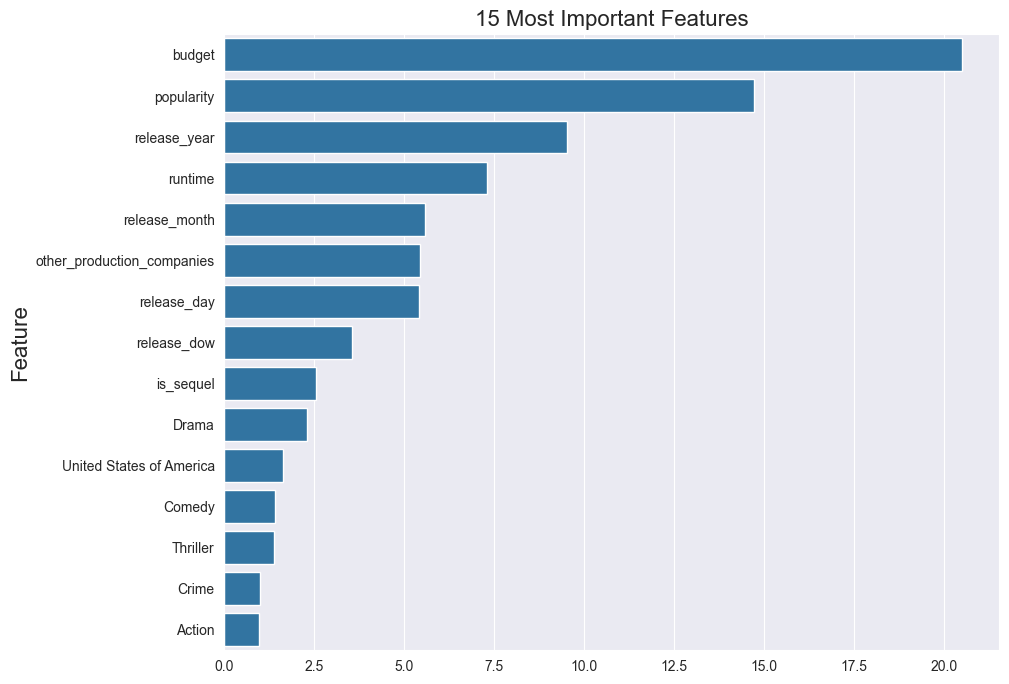

In [134]:
plot_feature_importance(feature_columns, cat_boost_reg.feature_importances_)

In [135]:
performance_measures(cat_boost_reg)

Train Mean RMSE: 2.2151, Train Mean R^2: 0.2810
Test Mean RMSE: 2.1080, Test Mean R^2: 0.3014


In [136]:
from sklearn.ensemble import VotingRegressor

named_estimators = [('cat_bost', cat_boost_reg), ('xgb_reg', xgb_reg), ('forest_reg', forest_reg), ('ridge_reg', ridge_reg)]

voting_reg = VotingRegressor(estimators=named_estimators, n_jobs=-1)
voting_reg.fit(X_train_transformed, y_train)

VotingRegressor(estimators=[('cat_bost',
                             <catboost.core.CatBoostRegressor object at 0x0000020952EB0ED0>),
                            ('xgb_reg',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=0.5,
                                          colsample_bynode=1,
                                          colsample_bytree=0.6,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=1.0,
                                          gpu_id=-1, grow_policy='depthwise',
                                          imp...
                                          max_depth=14, max_leaves=0,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=1000, n_jobs=-1,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, ...)),
                            ('forest_reg',
                             RandomForestRegressor(max_depth=16,
                                                   max_features=0.2,
                                                   n_estimators=500, n_jobs=-1,
                                                   random_state=42)),
                            ('ridge_reg', Ridge(alpha=1, random_state=42))],
                n_jobs=-1)

In [137]:
performance_measures(voting_reg)

Train Mean RMSE: 2.1992, Train Mean R^2: 0.2885
Test Mean RMSE: 2.1024, Test Mean R^2: 0.3040


### Saving the Pipeline

In [138]:
pipeline = Pipeline([('pre_process', pre_process),
                        ('voting_reg', voting_reg)])

In [139]:
pipeline.fit(X, np.log1p(y))

Pipeline(steps=[('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_cols', 'drop',
                                                  ['id', 'homepage', 'imdb_id',
                                                   'original_title',
                                                   'spoken_languages',
                                                   'overview', 'poster_path',
                                                   'tagline', 'title',
                                                   'crew']),
                                                 ('num_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['budget', 'popularit...
                                                           max_leaves=0,
                                                           min_child_weight=1,
                                                           missing=nan,
                                                           monotone_constraints='()',
                                                           n_estimators=1000,
                                                           n_jobs=-1,
                                                           num_parallel_tree=1,
                                                           predictor='auto',
                                                           random_state=42,
                                                           reg_alpha=0,
                                                           reg_lambda=1, ...)),
                                             ('forest_reg',
                                              RandomForestRegressor(max_depth=16,
                                                                    max_features=0.2,
                                                                    n_estimators=500,
                                                                    n_jobs=-1,
                                                                    random_state=42)),
                                             ('ridge_reg',
                                              Ridge(alpha=1, random_state=42))],
                                 n_jobs=-1))])

In [140]:
from joblib import dump

dump(voting_reg, "voting_reg.joblib")
dump(pre_process, "pre_process.joblib")

dump(pipeline, "pipeline.joblib")

print(f"Pipeline saved")

Pipeline saved


In [141]:
top_30_values

{'genres': ['Drama',
  'Comedy',
  'Thriller',
  'Action',
  'Romance',
  'Crime',
  'Adventure',
  'Horror',
  'Science Fiction',
  'Family',
  'Fantasy',
  'Mystery',
  'Animation',
  'History',
  'Music',
  'War',
  'Documentary',
  'Western',
  'Foreign',
  'TV Movie'],
 'production_companies': ['Warner Bros.',
  'Universal Pictures',
  'Paramount Pictures',
  'Twentieth Century Fox Film Corporation',
  'Columbia Pictures',
  'Metro-Goldwyn-Mayer (MGM)',
  'New Line Cinema',
  'Touchstone Pictures',
  'Walt Disney Pictures',
  'Columbia Pictures Corporation',
  'TriStar Pictures',
  'Relativity Media',
  'Canal+',
  'United Artists',
  'Miramax Films',
  'Village Roadshow Pictures',
  'Regency Enterprises',
  'BBC Films',
  'Dune Entertainment',
  'Working Title Films',
  'Fox Searchlight Pictures',
  'StudioCanal',
  'Lionsgate',
  'DreamWorks SKG',
  'Fox 2000 Pictures',
  'Summit Entertainment',
  'Hollywood Pictures',
  'Orion Pictures',
  'Amblin Entertainment',
  'Dimension F

In [142]:
encoded_cols

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 'other_genres',
 'Amblin Entertainment',
 'BBC Films',
 'Canal+',
 'Columbia Pictures',
 'Columbia Pictures Corporation',
 'Dimension Films',
 'DreamWorks SKG',
 'Dune Entertainment',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'Hollywood Pictures',
 'Lionsgate',
 'Metro-Goldwyn-Mayer (MGM)',
 'Miramax Films',
 'New Line Cinema',
 'Orion Pictures',
 'Paramount Pictures',
 'Regency Enterprises',
 'Relativity Media',
 'StudioCanal',
 'Summit Entertainment',
 'Touchstone Pictures',
 'TriStar Pictures',
 'Twentieth Century Fox Film Corporation',
 'United Artists',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney Pictures',
 'Warner Bros.',
 'Working Title Films',
 'other_production_companies',
 'Australia',
 'Austria',
 'Be